# Dungeons and Data

A scientific approach to stupid questions that dice rollers care about.  Also a means to train myself in python, numpy, padas, matplotlib, and other tools so I'm not totally reliant on R.

### Attack Bonus vs Damage Bonus

Having played for several years since the release of 3rd edition I find myself playing a 5th edition campaign as a ranger.  Rangers must choose a fighting style and I was torn between choosing archery and and dueling.  Archery grants a +2 bonus to attacks with ranged weapons and dueling grantgs a +2 bonus to damage when fighting with a single melee weapon.  Since attacks and damage are two complementary parts of killing enemies, I thought I'd take a look into which was the better choice.

### Data
I acquired a dataset of (I think) all the monsters in the 5th edition Monster Manual with some key stats.  The stats I'm most interested in, however, are Challenge Rating (so see how difficult a monster is supposed to be to kill) and Armor Class (to see how difficult a monster is to hit).  We load that here.

From the Dungeon Master's Basic Rules p.5:


> A monster’s challenge rating tells you how great a
threat the monster is. An appropriately equipped and
well-rested party of four adventurers should be able to
defeat a monster that has a challenge rating equal to its
level without suffering any deaths. For example, a party
of four 3rd-level characters should find a monster with
a challenge rating of 3 to be a worthy challenge, but not
a deadly one.



In [7]:
%matplotlib inline
import pandas as pd, numpy as np

In [112]:
monsterStats = pd.read_csv("5eMonsters.csv")

In [113]:
monsterStats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 0 to 427
Data columns (total 10 columns):
name    428 non-null object
type    428 non-null object
aln     428 non-null object
ac      428 non-null int64
hp      428 non-null int64
spc     428 non-null object
at1     423 non-null object
at2     216 non-null object
p       428 non-null int64
crd     428 non-null float64
dtypes: float64(1), int64(3), object(6)
memory usage: 36.8+ KB


428 entries.  Tangentially, it's impressive how many distinct monsters WotC packs into the MM, even after you account for the 40 entries consisting of the cross product of Dragon**x**[Color]**x**[Age] and the 28 "giant" varieties of a bunch of mundane animals.

In [114]:
monsterStats[['name','ac', 'crd']][:12]

,name,ac,crd
0,Aarakocra,12,0.25
1,Aboleth,17,10.00
2,Abominable Yeti,15,9.00
3,Acolyte,10,0.25
4,Air Elemental,15,5.00
5,Allosaurus,13,2.00
6,Androsphinx,17,17.00
7,Animated Armor,18,1.00
8,Ankheg,14,2.00
9,Ankylosaurus,15,3.00


Let's look at how they're distributed by challenge rating.

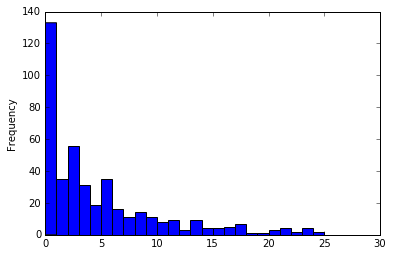

In [115]:
monsterStats['crd'].plot(kind='hist', bins = np.arange(0,max(monsterStats['crd']), 1))

Lots of monsters with CR zero.  How can that be?  It turns out there are a lot of kind of offal creatures that are listed just in case it comes up, like beetles, swarms of flies, etc. Some of them even have fractional CRs.

In [117]:
monsterStats[['name','crd','ac']].sort_values(['crd'])[:20]

,name,crd,ac
94,Deer,0,13
348,Shrieker,0,5
342,Sea Horse,0,11
339,Scorpion,0,11
210,Hawk,0,13
27,Bat,0,12
317,Raven,0,12
316,Rat,0,10
314,Quipper,0,13
219,Homunculus,0,13


As a player, I'm much less concerned with fighting seahorses, so let's remove all the monsters with CR less than 1 and work with that from now on.

In [118]:
monsterStats = monsterStats[monsterStats['crd'] >= 1]

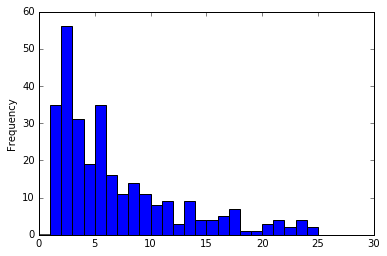

In [119]:
monsterStats['crd'].plot(kind='hist', bins = np.arange(0,max(monsterStats['crd']), 1))

That's better.

Let's look at how many monsters there are with each armor class.  

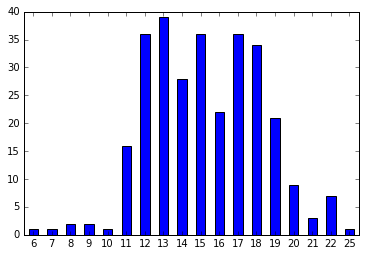

In [120]:
monsterStats['ac'].value_counts().sort_index(0).plot(kind='bar', rot=0)

Pretty stark block of ACs in the 12-19 range.  Including the fluff monsters shows a much more normal curve, though.

There are a couple of ways we can link AC and CR.  Let's start by seeing what the average AC is for each CR.

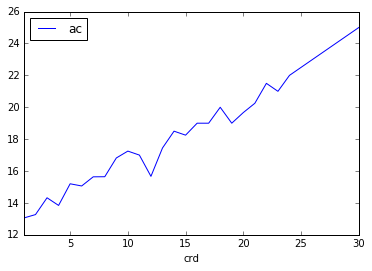

In [122]:
monsterStats[['crd','ac']].groupby(['crd']).mean().plot(rot=0)

Pretty linear progression.  Later we'll fit a regression to this: I expect it'll be something like $ \hat{y} = 13.5 + 1crd$

We can relate the two in a scatterplot to get a better sense of the distribution, too.

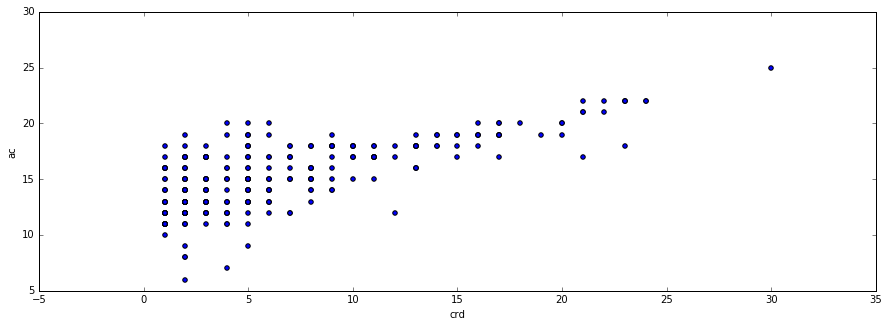

In [123]:
monsterStats.plot(kind="scatter", x='crd',y='ac', figsize=[15,5])

This gives us a better idea.  The variance of AC is much higher at lower CRs; as CR increases the ACs are much more consistent.  This, from a gameplay perspective, is because at higher levels mosnters have other ways of being dangerous besides being harder to hit.  At low levels the monsters can't be too deadly with abilities because they'll just murder the party, so to differentiate monsters the base stats are more different.

The problem here is that if more than one monster have the same (cr, ac) combo they'll plot on top of one another, so this isn't a great representation of the density of stats.  Next we'll plot the density of the combinations of stats.

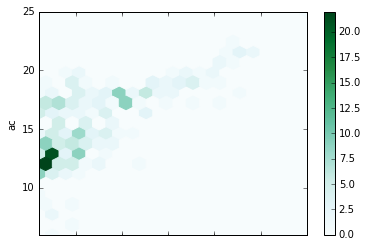

In [125]:
monsterStats.plot(kind="hexbin", x='crd',y='ac', gridsize=20)

This shows us the absolute density of (cr, ac) pairs.  This makes it clear that at levels 1-3 most of the monsters have AC betwen 11 and 14.